# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [4]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, feature, fergus, fall, bakery, mi..."
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...,"[[Sen, Klobuchar, Showcases, Local, Efforts, t...","[[sen, klobuchar, showcase, local, effort, com..."
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...,"[[Klobuchar, Urges, Fellow, Senators, to, Supp...","[[klobuchar, urge, fellow, senator, support, w..."
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...,"[[Senator, Klobuchar, Wins, Passage, of, Cellu...","[[senator, klobuchar, win, passage, cellulosic..."
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...,"[[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...","[[klobuchar, give, yellow, ribbon], [place, ar..."
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...,"[[Sen, Klobuchar, Statement, in, Observance, o...","[[sen, klobuchar, statement, observance, memor..."
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...,"[[Klobuchar, Secures], [2, 5, Million, for, Ve...","[[klobuchar, secure], [veteran, education, hea..."
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, pass, committee]..."
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...,"[[Sen, Klobuchar, Urges, Minnesotans, Travelin...","[[sen, klobuchar, urge, minnesotans, travel, c..."
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...,"[[Klobuchar, Co, sponsors], [Emergency, LIHEAP...","[[klobuchar, co, sponsor], [emergency, liheap,..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [5]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [6]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([-1.2149085 ,  0.40176535, -0.514346  , -1.0094081 , -0.11980339,
       -0.12192902,  2.6773496 , -0.6456307 , -1.4406614 , -1.8003329 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[ 8.0553597e-01, -6.5552002e-01, -1.1311110e+00, ...,
        -9.7755033e-01, -9.5489734e-01,  7.4224001e-01],
       [-3.1423852e-01,  1.2552075e+00,  3.6330512e-01, ...,
         5.6413811e-01,  1.0861852e+00, -1.7277771e-01],
       [-3.7741043e-02, -8.5736430e-01, -2.9136628e-01, ...,
        -8.1839710e-01, -2.5425979e-01, -1.0865759e+00],
       ...,
       [-4.2646244e-02, -4.6264753e-02,  5.2682180e-03, ...,
        -1.3122146e-02,  9.3657188e-03, -3.8289752e-02],
       [ 4.5632817e-02, -4.2338926e-02,  6.6016447e-03, ...,
         4.2817187e-03, -1.1910541e-03, -5.2309535e-02],
       [-1.8144807e-02, -2.6708275e-02, -1.8438864e-02, ...,
        -2.5656436e-02,  2.5888633e-02, -1.9631494e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'today'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.7922083139419556),
 ('rollback', 0.6283433437347412),
 ('cheney', 0.5697973966598511),
 ('trim', 0.5478677749633789),
 ('george', 0.5434622764587402),
 ('unchallenged', 0.5406987071037292),
 ('ronald', 0.5332279205322266),
 ('presidential', 0.5282188653945923),
 ('presidency', 0.5195102691650391),
 ('speech', 0.513523519039154)]

In [10]:
senReleasesW2V.most_similar('war')

[('invade', 0.6512746214866638),
 ('afghanistan', 0.636878252029419),
 ('disobedience', 0.6079409718513489),
 ('unresisted', 0.6022642850875854),
 ('insurgency', 0.5994513034820557),
 ('resemblance', 0.5749073028564453),
 ('invasion', 0.5713664889335632),
 ('chaos', 0.5676052570343018),
 ('quagmire', 0.55875164270401),
 ('escalation', 0.5538773536682129)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('johnson', 0.820692777633667),
 ('nixon', 0.7703591585159302),
 ('reagan', 0.7371204495429993),
 ('richard', 0.7305401563644409),
 ('ford', 0.7131854891777039),
 ('watson', 0.7091400623321533),
 ('travaglini', 0.7091015577316284),
 ('dick', 0.7050381898880005),
 ('miller', 0.7031209468841553),
 ('dwight', 0.7003613710403442)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.805536  , -0.65552   , -1.131111  , ..., -0.9775503 ,
        -0.95489734,  0.74224   ],
       [-0.31423852,  1.2552075 ,  0.36330512, ...,  0.5641381 ,
         1.0861852 , -0.17277771],
       [-0.03774104, -0.8573643 , -0.29136628, ..., -0.8183971 ,
        -0.2542598 , -1.0865759 ],
       ...,
       [ 0.43972668, -1.6121485 ,  0.7022346 , ..., -1.1030133 ,
         0.5420161 , -0.59464234],
       [-0.515967  ,  1.183087  ,  0.9804852 , ...,  2.64713   ,
        -0.54898566, -0.601656  ],
       [ 0.48278186, -0.0726252 ,  0.5858207 , ..., -1.0067066 ,
        -0.30949754, -0.11195393]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [16]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

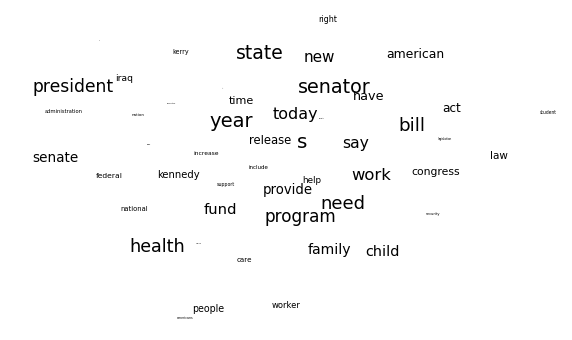

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [18]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [19]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [20]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000105381012
Wuhan


Second, location analogy: **country -> capital**

In [21]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [22]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [23]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

My project will be mainly based on content analysis on economic literature (Possibly more social science literatures if I can get access to.). Therefore, I crawled all abstract of working papers (not peer reviewed) on NBER to start with.

### Data Cleaning

In [7]:
import datetime

In [8]:
nber_df = pandas.read_csv('/Users/yslin624/Dropbox/Content Analysis/data/nber/nber_abstraction_full.csv', index_col = False)
nber_df = nber_df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

In [9]:
def remove_char(text, string):
    s = text.replace(string, '')
    return s

def month_replacement(date):
    MonthDict={  "January" : '01',
       "February" : '02',
       "March" : '03',
       "April" : '04',
       "May" : '05',
       "June" : '06',
       "July" : '07',
       "August" : '08',
       "September" : '09',
       "October" : '10',
       "November" : '11',
       "December" : '12'  
    }
    date_list = date.split()
    date = date.replace(date_list[0], MonthDict[date_list[0]])
    
    return date

def time_conversion(date):
    date = date.strip()
    date = datetime.datetime.strptime(date, '%m %Y')
    return date

def list_conversion(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.replace("'", '')
    s = s.split(',')
    return s


In [10]:
nber_df['date'] = nber_df.apply(lambda row: remove_char(row['date'], '\n'), axis = 1)
nber_df['date'] = nber_df.apply(lambda row: remove_char(row['date'], 'Issue'), axis = 1)
nber_df['text'] = nber_df.apply(lambda row: remove_char(row['text'], '\n'), axis = 1)
nber_df['date'] = nber_df.apply(lambda row: remove_char(row['date'], 'Date'), axis = 1)

nber_df['date'] = nber_df.apply(lambda row: month_replacement(row['date']), axis = 1)
nber_df['date'] = nber_df.apply(lambda row: time_conversion(row['date']), axis = 1)

nber_df['genre'] = nber_df.apply(lambda row: list_conversion(row['genre']), axis = 1)
nber_df['authors'] = nber_df.apply(lambda row: list_conversion(row['authors']), axis = 1)


Focus on a small amount of data first, say one-fifth, sampled by simple multiple of 5.

In [11]:
nber_df['id'] = nber_df.apply(lambda row: int(row['id']), axis = 1)
sample_df = nber_df

### Word2Vec

In [12]:
#Apply our functions, notice each row is a list of lists now
sample_df['tokenized_sents'] = sample_df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
sample_df['normalized_sents'] = sample_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])


In [13]:
nberW2V = gensim.models.word2vec.Word2Vec(sample_df['normalized_sents'].sum())

In [14]:
# The similarity in this case is not that fit in "common sense" similarity
# like "dictatorship", "autocracy" and "centralization".
nberW2V.most_similar('democracy')

[('democratic', 0.7440026998519897),
 ('dictatorship', 0.692566990852356),
 ('autocracy', 0.6923662424087524),
 ('centralization', 0.6804579496383667),
 ('liberal', 0.6743656992912292),
 ('electoral', 0.6649995446205139),
 ('elite', 0.6530683636665344),
 ('political', 0.6468183994293213),
 ('democratization', 0.6196228265762329),
 ('polity', 0.6139534115791321)]

In [15]:
# This is very within context, most are very macroeconomic topics.
nberW2V.most_similar('macroeconomic')

[('macro', 0.7105730772018433),
 ('monetary', 0.6621171236038208),
 ('economic', 0.6323248744010925),
 ('fiscal', 0.6043261289596558),
 ('propagation', 0.5833579301834106),
 ('fundamental', 0.5535613894462585),
 ('inflationary', 0.5419635772705078),
 ('quantitative', 0.5288969278335571),
 ('microeconomic', 0.5201122760772705),
 ('expansionary', 0.4867556691169739)]

In [16]:
# This still makes some sense as "macroeconomic" and "aggregate" is in this addition and subtraction.
nberW2V.most_similar(positive=['micro', 'macro'], negative = ['microeconomics'], topn = 5)

[('microeconomic', 0.6419014930725098),
 ('sectoral', 0.5802023410797119),
 ('aggregate', 0.5670484304428101),
 ('disaggregate', 0.5666002035140991),
 ('macroeconomic', 0.4939768314361572)]

In [17]:
# PCA preparation
numWords = 50
targetWords = nberW2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(nberW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

In [18]:
pcaPlot = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
pcaPlots = pcaWords.transform(wordsSubMatrix)

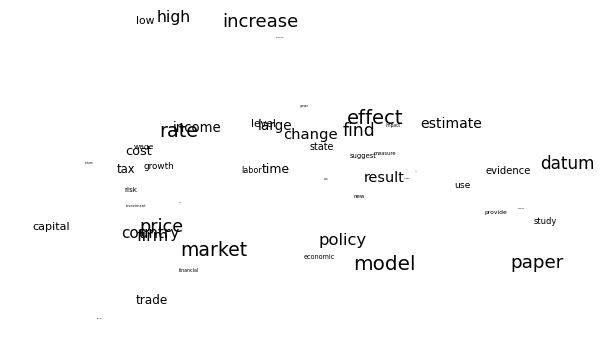

In [19]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(pcaPlots[:, 0], pcaPlots[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (pcaPlots[:, 0][i],pcaPlots[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

There is less to see in this, and far more spare than TSNE. I suspect that a two dimension visualization is too low-dim for academic papers, which usually have very different methods when coming to different topics.

In [20]:
# T-SNE preparation

# T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

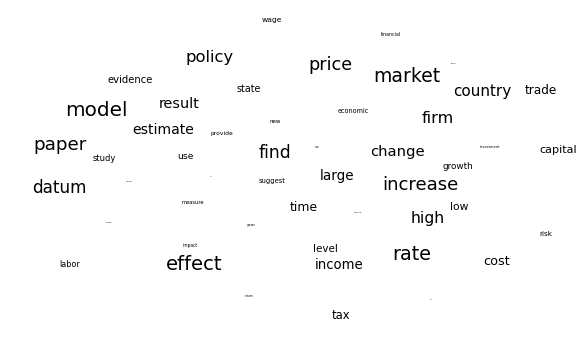

In [21]:

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

I suspect there will be quite different result when we see some other social sciences paper on economics or broader social issues. It is interesting to see how "model" and "estimate" are so important, even more than market, which hints on the fact that the need to provide a mathematical based theoretical framework.

Also we can see a bit cluster of different domains. Investment, firm and capital are mostly topics when mentioning macroeconomics, and tend to be not very closely discussed with topics like labor and wage. And when it comes to income, the direct and closest link would be tax.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [39]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [40]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [41]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [42]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [43]:
taggedDocs

[LabeledSentence(words=['summarizing', 'account', 'given', 'research', 'barium', 'titanate', 'progress', 'laboratory', 'insulation', 'research', 'm.', 'i.', 't.', 'investigations', 'led', 'understanding', 'mechanism', 'ferroelectricity', 'titanates', 'discoveries', 'piezoelectric', 'effect', 'ceramics', 'domain', 'structure', 'single', 'crystals', 'batio3', 'high', 'dielectric', 'constant', 'field', 'strength', 'temperature', 'sensitivity', 'piezo', 'response', 'barium', 'titanate', 'dielectrics', 'useful', 'numerous', 'technical', 'applications'], tags=[1950, '10.1103/RevModPhys.22.221']),
 LabeledSentence(words=['new', 'tables', 'coulomb', 'functions', 'presented', 'introduction', 'use', 'ranges', 'parameters', 'covered', 'tabulations', 'required', 'calculation', 'reactions', 'protons', 'deuterons', 'alpha', 'particles', 'lighter', 'nuclei', 'hydrogen', 'oxygen', 'energy', 'range', 'mev', 'alpha', 'particles', 'tables', 'suffice', 'treatment', 'reactions', 'mev', 'z=9', 'f', 'mev', '

Now we can train a Doc2Vec model:

In [44]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [45]:
apsD2V.docvecs[1952]

array([ 0.61869884, -1.0802084 ,  0.4902816 , -1.2053727 ,  0.90056807,
        1.2046617 ,  0.646905  , -0.43232417,  1.3848633 , -1.4432577 ,
        0.8593458 , -0.15810046, -0.26975003,  2.0504892 , -0.6661519 ,
        0.861853  , -0.1462042 , -1.4783434 , -0.43029898,  1.8257389 ,
        0.57658345, -0.7931958 ,  0.5366083 ,  0.796267  ,  0.7879168 ,
        0.2214361 , -0.71150905, -0.15432209,  0.564367  ,  0.27460715,
        1.4227353 , -1.7972426 ,  1.5568315 , -0.44743827, -1.2799468 ,
       -0.41872963, -0.45738214,  1.1758322 ,  1.1945492 , -1.5232092 ,
       -0.42219892, -1.2632024 , -1.7315611 ,  1.7676668 , -1.048435  ,
       -0.59068954,  1.1347744 ,  1.0414456 , -1.8597355 , -1.2213988 ,
        0.30473557, -0.0748622 ,  1.3238919 , -0.07984557,  0.14435737,
        1.3247029 ,  1.366605  , -0.9517673 , -1.0807381 ,  0.1273581 ,
       -0.8175874 , -0.02439585,  1.7952626 , -0.46602255, -0.2717474 ,
       -0.54063773, -1.0259092 , -0.7794781 ,  1.2140135 ,  0.84

The words can still be accessed in the same way:

In [46]:
apsD2V['atom']

array([ 0.5278025 , -0.08227769,  0.6802149 ,  0.23610893, -0.21098086,
        1.3005596 ,  0.44533423,  0.40324047,  0.22388043,  0.20561835,
        1.022954  , -1.3907896 ,  0.06174132, -0.49506256,  0.18834904,
       -0.2669796 , -0.28135005, -1.0013294 , -0.456351  ,  0.14967853,
        0.3049265 , -0.13038525,  1.1828077 , -0.00276864,  0.14069742,
       -0.11243521,  0.5155114 ,  0.18830645, -0.47050786,  0.12185226,
        0.03225173, -0.6820654 ,  0.922321  ,  0.13916084,  0.7230717 ,
        0.13948372,  0.9892285 , -0.02908098,  0.21496716, -0.9419909 ,
       -0.40760082,  0.29959196, -0.91817117,  0.6407242 ,  0.8633021 ,
       -0.16854164,  0.08331034,  0.8028999 ,  0.16717067,  0.1375415 ,
        0.20599218,  0.3005247 , -0.1596208 , -0.11595816,  0.40138772,
        0.06774338,  0.72134507,  0.11416518, -0.46557793, -0.07740252,
        0.8991774 , -0.28216416,  0.9021879 , -0.07674855, -0.6989701 ,
       -0.8655115 , -0.20222305, -0.00548437,  0.2193863 ,  1.58

We can still use the ``most_similar`` command to perform simple semantic equations:

In [47]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7877671718597412)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [48]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('fluid', 0.9324870109558105)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [49]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.60671115]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [50]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.84.457', 0.7626417279243469),
 ('10.1103/PhysRev.113.479', 0.6466288566589355),
 ('10.1103/PhysRev.112.812', 0.6401161551475525),
 ('10.1103/PhysRev.105.1469', 0.6284803152084351),
 ('10.1103/PhysRev.109.1076', 0.6227775812149048)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

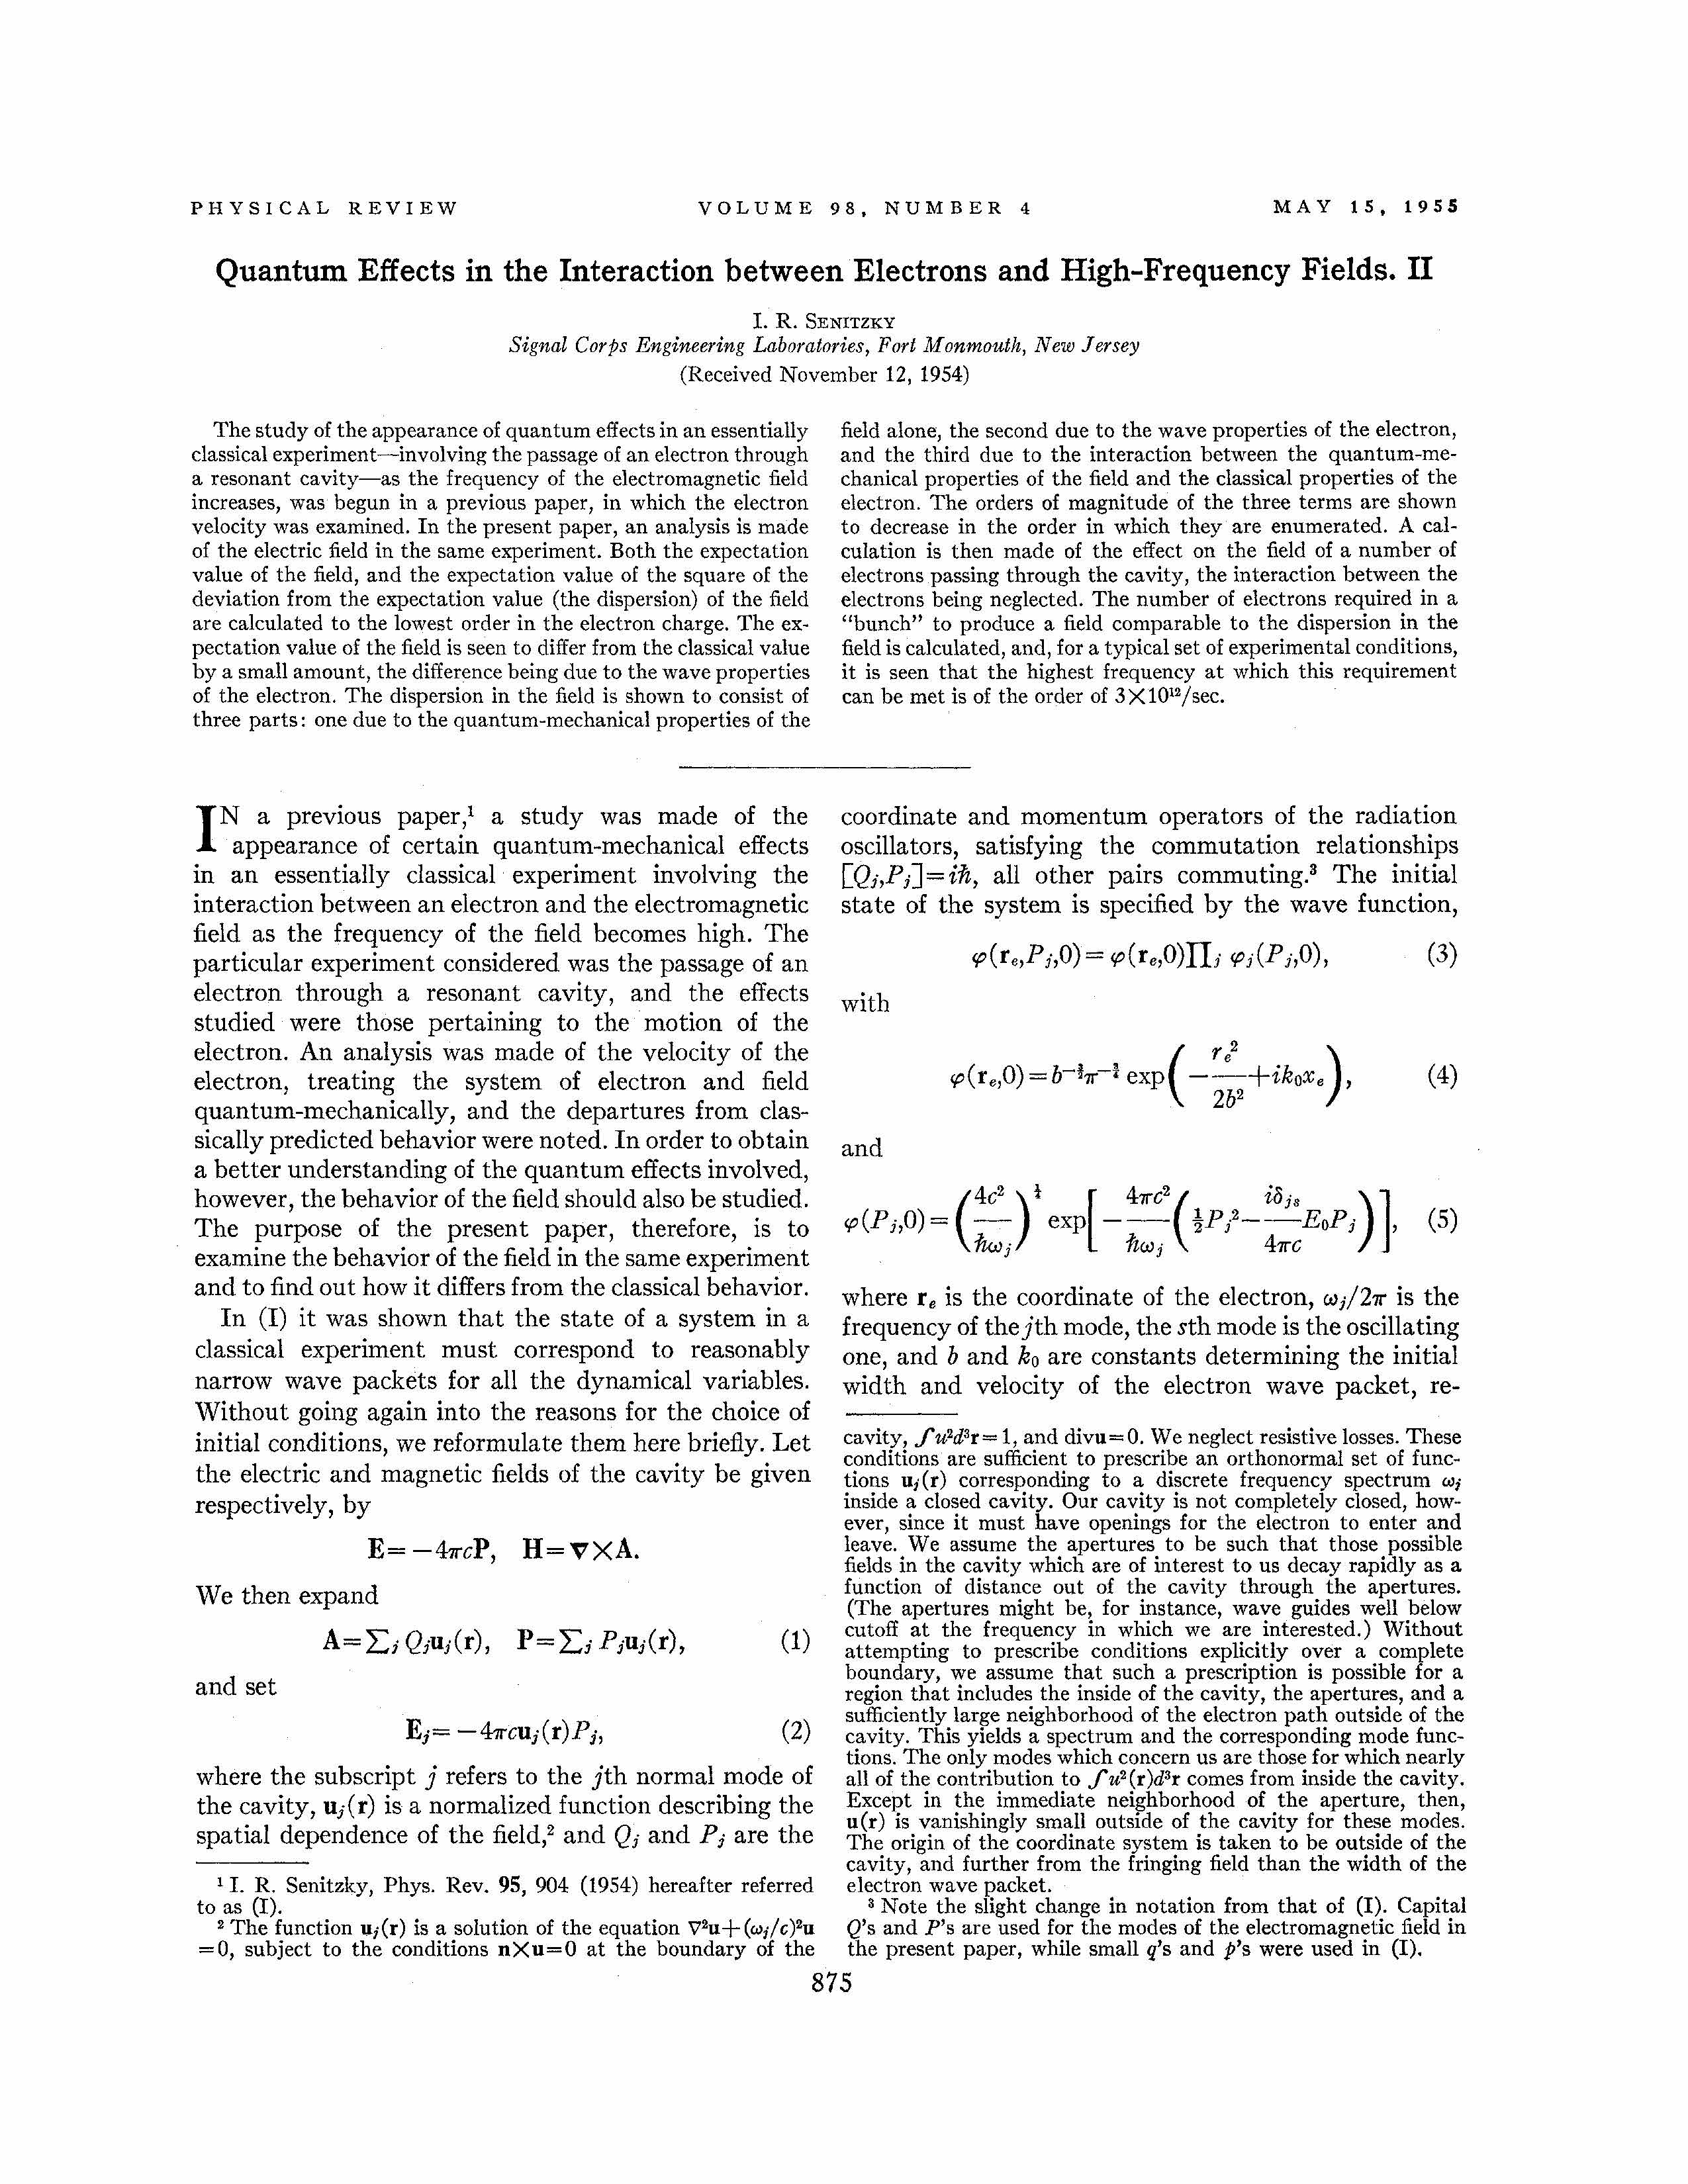

In [51]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [52]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('attained', 0.7415313720703125),
 ('great', 0.6951518654823303),
 ('straight', 0.6925736665725708),
 ('imprisonment', 0.6772764921188354),
 ('electric', 0.6736010909080505)]

We can even look for documents most like a query composed of multiple words:

In [53]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.81.244', 0.7513400912284851),
 ('10.1103/PhysRev.110.307', 0.750105619430542),
 ('10.1103/PhysRev.115.1277', 0.7432439923286438),
 ('10.1103/PhysRev.115.1537', 0.7366885542869568),
 ('10.1103/PhysRev.89.386', 0.7266430854797363)]

Now let's plot some words and documents against one another with a heatmap:

In [54]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

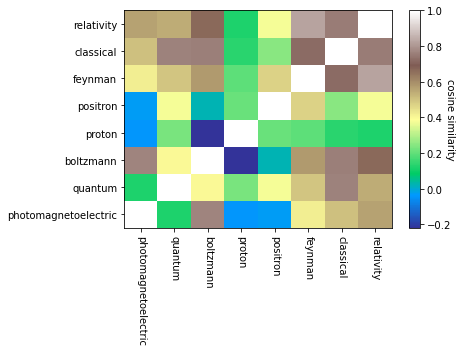

In [55]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [56]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

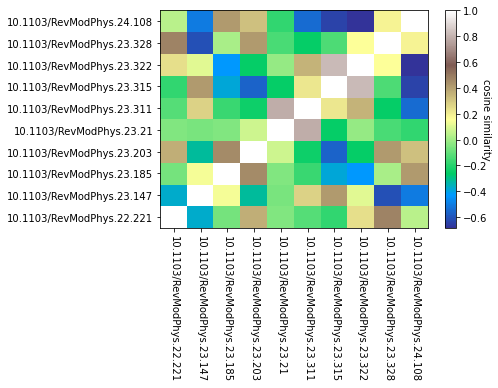

In [57]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [58]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

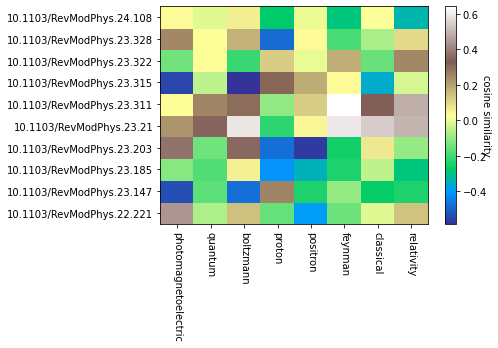

In [59]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [60]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

We can do a sampling on specific fields, focusing on the genre, maybe including public ecnomics or stuff like that, and see if we can obtain a better result.

In [22]:
# Obtain a rough sense of what economic topics were included
# Notice this is not exactly partitioned, thus the total sum should be > 29000
unique_genre = {}
for row in sample_df['genre']:
    if row == ['0']:
        continue
    else:
        for i in row:
            i = i.strip()
            if i in unique_genre.keys():
                unique_genre[i] += 1
            else:
                unique_genre[i] = 1
                

In [23]:
unique_genre

{'Economic Fluctuations and Growth': 5699,
 'International Trade and Investment': 3502,
 'International Finance and Macroeconomics': 4090,
 'Public Economics': 5762,
 'Labor Studies': 5771,
 'Health Economics': 2384,
 'Monetary Economics': 3261,
 'Productivity': 2404,
 'Innovation': 2404,
 'and Entrepreneurship': 2404,
 'Law and Economics': 1140,
 'Children': 1657,
 'Corporate Finance': 2303,
 'Economics of Aging': 1618,
 'Development of the American Economy': 1509,
 'Environment and Energy Economics': 1219,
 'Industrial Organization': 1692,
 'Asset Pricing': 2649,
 'Health Care': 1654,
 'Economics of Education': 1569,
 'Political Economy': 1279,
 'Technical Working Papers': 282,
 'Development Economics': 1207}

In [24]:
keywords = list(unique_genre.keys())

In [25]:
sample_df['decade'] = sample_df.apply(lambda row: int(int(row['date'].strftime('%Y'))/10) *10, axis = 1)
sample_df['tokenized_words'] = sample_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
sample_df['normalized_words'] = sample_df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [26]:
taggedDocs = []
for index, row in sample_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['genre']]
    docKeywords.append(row['decade'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
sample_df['TaggedAbstracts'] = taggedDocs

In [27]:
nberD2V = gensim.models.doc2vec.Doc2Vec(sample_df['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


### Word algebra

Play around with this result and see what interesting might come up

In [28]:
# This subtraction again doesn't fully reflect the "feminine" feature of context analysis.
nberD2V.most_similar(positive = ['fathers','men'], negative = ['women'], topn = 5)

[('females', 0.8016916513442993),
 ('unmarried', 0.7959249019622803),
 ('marry', 0.7835605144500732),
 ('husbands', 0.7781655788421631),
 ('hispanics', 0.774470329284668)]

In [29]:
nberD2V.most_similar(positive = ['mother'], topn = 10)

[('father', 0.9084019064903259),
 ('adult', 0.8702981472015381),
 ('sons', 0.8667802810668945),
 ('mothers', 0.8666130304336548),
 ('adolescent', 0.852592945098877),
 ('fathers', 0.8506358861923218),
 ('adoptive', 0.845695972442627),
 ('sex', 0.8240773677825928),
 ('adulthood', 0.8116872906684875),
 ('boys', 0.8027516603469849)]

In [30]:
# This actually shows some form of time trend in economic studying.
# So the study of "money" is particularly flourishing in 1970,80, then it quickly died out.
nberD2V.docvecs.most_similar([ nberD2V['money'] ], topn = 5)

[('Monetary Economics', 0.5454496145248413),
 (1970, 0.37620753049850464),
 (1980, 0.3584378957748413),
 (1594, 0.31886252760887146),
 (389, 0.3123592734336853)]

In [31]:
nberD2V.docvecs.most_similar([ nberD2V['race'] ], topn = 5)

[('Children', 0.43318742513656616),
 ('Economics of Education', 0.4157617688179016),
 (454, 0.3354234993457794),
 ('Labor Studies', 0.32176247239112854),
 (1990, 0.3020191490650177)]

In [32]:
# This is not very surprising, as Asset pricing is fundamentaly related to stocks(equity), bond and speculation.
nberD2V.most_similar([nberD2V.docvecs['Asset Pricing']], topn=5) 

[('hedge', 0.6782866716384888),
 ('stocks', 0.5915814638137817),
 ('bubble', 0.5899949669837952),
 ('volatility', 0.5808151960372925),
 ('herding', 0.5778914093971252)]

In [33]:
# We can get the most important topics in labor study.
nberD2V.most_similar([nberD2V.docvecs['Labor Studies']], topn= 10) 

[('worker', 0.5373411774635315),
 ('job', 0.5329285860061646),
 ('layoffs', 0.5189497470855713),
 ('seekers', 0.5128918886184692),
 ('vacancies', 0.5061231851577759),
 ('interfering', 0.4928843080997467),
 ('underemployment', 0.4928688406944275),
 ('jobs', 0.4923241436481476),
 ('jobseekers', 0.4896414279937744),
 ('workers', 0.48856326937675476)]

In [34]:
test = keywords[:8]
heatmapMatrix = []

for tagOuter in test:
    column = []
    tagVec = nberD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in test:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nberD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)

heatmapMatrix = np.array(heatmapMatrix)

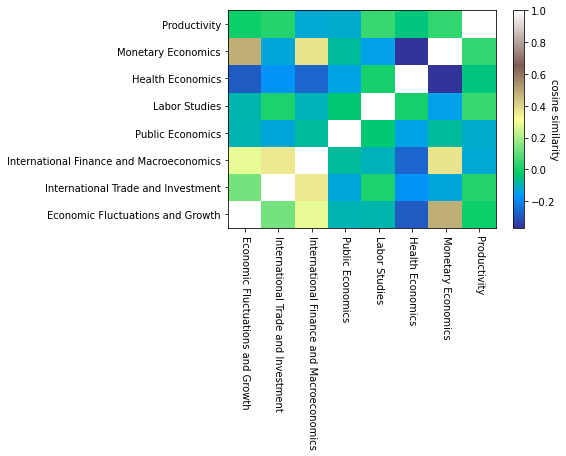

In [35]:
# I think this graph clearly shows the divergence of topics
# Monetary, International Finance aand Economic fluctuation are all macro economic topics, thus have high similarity
# While others are more micro economics, thus are much more similar to each other
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap = 'terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation = 270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(test, minor=False, rotation=270)
a = ax.set_yticklabels(test, minor=False)

In [36]:
test = [1970, 1980, 1990, 2000, 2010]
# There should be something wrong with this whole shit
heatmapMatrix = []
for tagOuter in test:
    column = []
    tagVec = nberD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in test:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nberD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

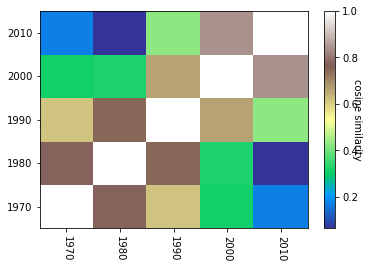

In [37]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(test, minor=False, rotation=270)
a = ax.set_yticklabels(test, minor=False)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [120]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [123]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [158]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

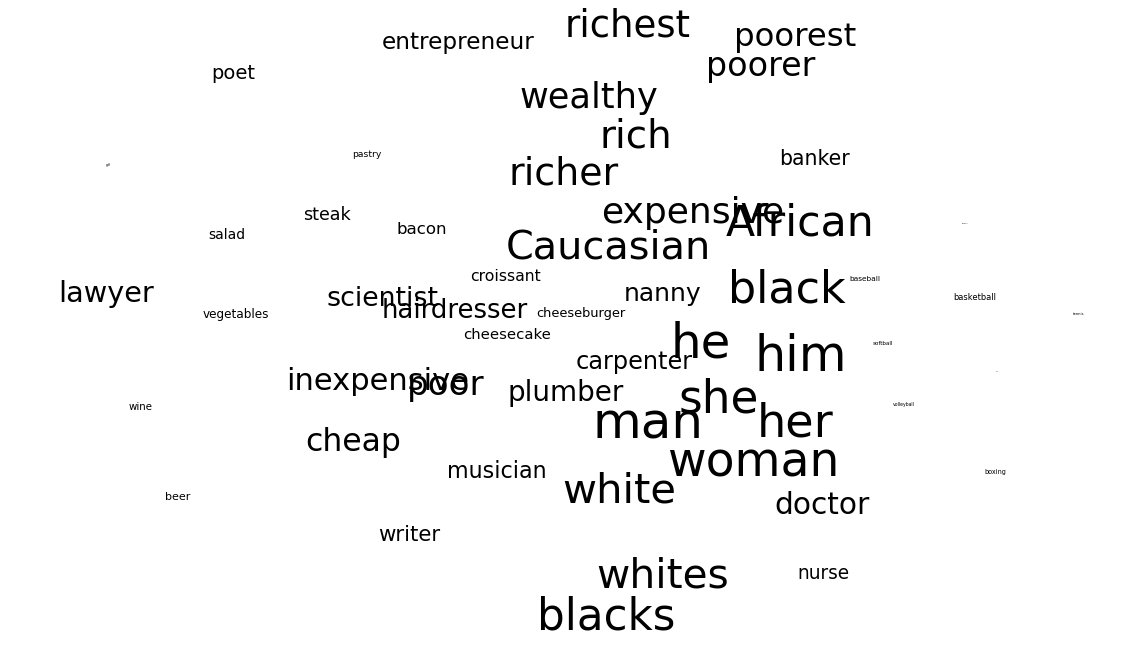

In [159]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [160]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [161]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [162]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [163]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [164]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [165]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

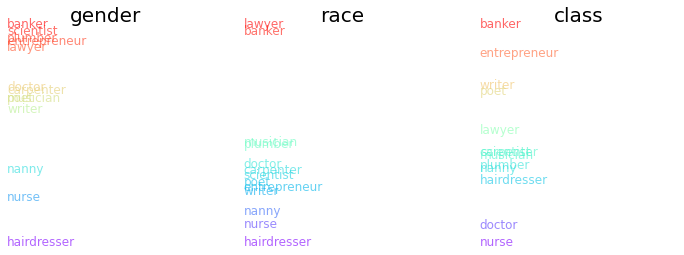

In [166]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

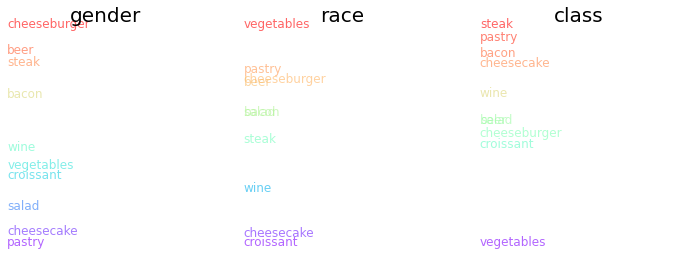

In [167]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

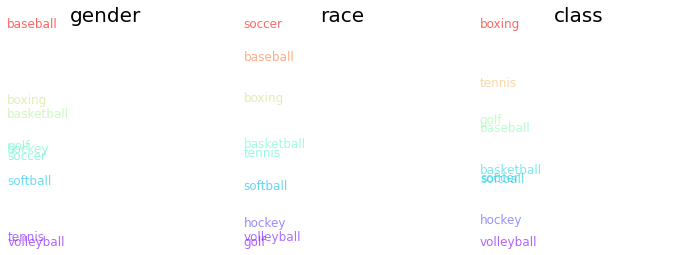

In [168]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

Semantic dimension like the above "cultural" case seems a bit hard to come up with in a academic field. Therefore, I will only try it on some easy case, such as micro and macro, maybe affluence as well. (I will not include gender here, as it is very likely in an academic work case that context won't reflect feminism and gender.)

In [38]:
nber_voc = nberW2V.wv.index2word

In [39]:
# First see what we have to create a dimension.
target_words = ['large', 'big', 'huge', 'high', 'substantial', 'tiny', 'little', 'small', 'low', 'insignificant', 'rich', 'expensive', 'wealthy', 'poor', 'cheap', 'needy', 'micro', 'microeconomic', 'microeconomics', 'macro', 'macroeconomic', 'macroeconomics']

# Selected words from nber_voc to get some sensible result (ideally)
target_words += ['capital', 'tax', 'wage', 'investment', 'bank', 'asset', 'government', 'household', 'industry', 'inflation', 'behavior', 'welfare', 'insurance', 'foreign', 'local', 'family', 'unemployment', 'house', 'fiscal', 'development', 'law', 'efficiency', 'environment', 'employer', 'employee', 'immigrant', 'white', 'black', 'alcohol']

wordsSubMatrix = []
for word in target_words:
    wordsSubMatrix.append(nberW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

In [40]:
pcaWordsnber = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_datanber = pcaWordsnber.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsnber = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datanber)

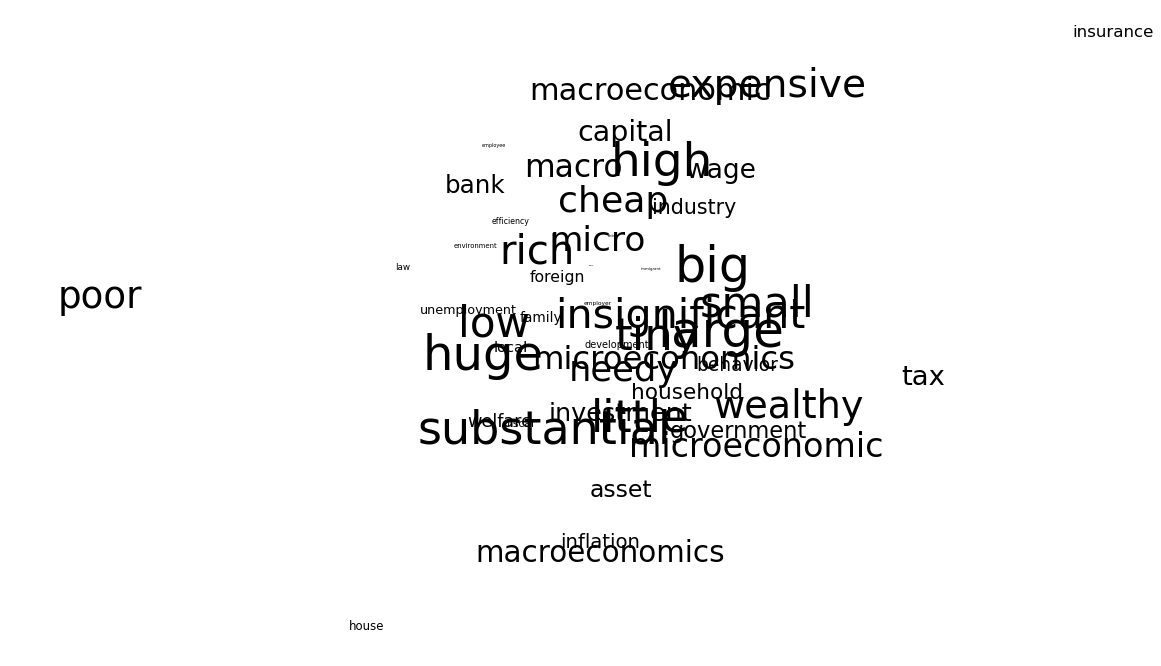

In [41]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsnber[:, 0], tsneWordsnber[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(target_words):
    ax.annotate(word, (tsneWordsnber[:, 0][i],tsneWordsnber[:, 1][i]), size =  50 * (len(target_words) - i) / len(target_words))
plt.xticks(())
plt.yticks(())
plt.show()

In [42]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [43]:
size = dimension(nberW2V, ['large', 'big', 'huge', 'high', 'substantial'], ['tiny', 'little', 'small', 'low', 'insignificant'])
field = dimension(nberW2V, ['micro', 'microeconomic', 'microeconomics'], ['macro', 'macroeconomic', 'macroeconomics'])
wealth = dimension(nberW2V, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'needy'])

In [44]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nberW2V[word].reshape(1,-1), size.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nberW2V[word].reshape(1,-1), field.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nberW2V[word].reshape(1,-1), wealth.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'size': g, 'field': r, 'wealth': c}, index = word_list)
    return df

In [45]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [46]:
word_list = ['capital', 'tax', 'wage', 'investment', 'bank', 'asset', 'government', 'household', 'industry', 'inflation', 'behavior', 'welfare', 'insurance', 'foreign', 'local', 'family', 'unemployment', 'house', 'fiscal', 'development', 'law', 'efficiency', 'environment', 'employer', 'employee', 'immigrant', 'white', 'black', 'alcohol']

In [47]:
testDF = makeDF(nberW2V, word_list)

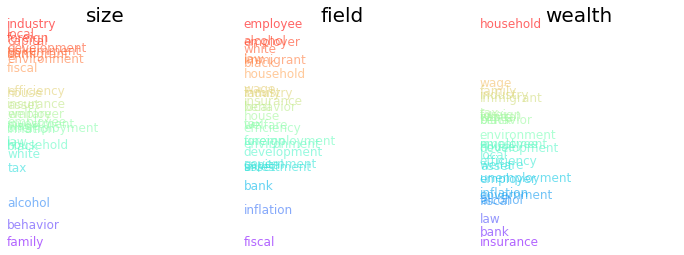

In [48]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, testDF, 'size')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, testDF, 'field')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, testDF, 'wealth')
plt.show()

### Size
It's not surprising that tax is small in size, as these are economic papers. It is a bit surprising "local" is so high on the size ladder and family is sos small. 

### Field
This column reflects a lot about what topics are hot in micro and macro economics. Employee, employer, immigrant and household are micro topics. Fiscal, iniflation, bank and development are macro topics. While efficiency is a relatively nuetral word, which is important in both field.

### Wealth
Insurance is linked to low wealth, which is quite intuitive. However, bank and law is low wealth, household, immigrant, family is linked to high wealth, which is quite counterintuitive. Porbably worth looking more into it.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [107]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [108]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [109]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
...,...,...,...,...,...,...,...,...,...,...
95,157791,Golden Living,"Here at Golden LivingCenters, we rely on and t...",Nebraska,40.67667,-95.85917,High school diploma or equivalent;Must within ...,NaN,"[[Here, at, Golden, LivingCenters, ,, we, rely...","[[here, at, golden, livingcenters, we, rely, o..."
96,119835,GameStop,"""*Description* Description: SUMMARY At GameSto...",New York,40.68149,-73.39984,NaN,NaN,"[[``, *Description*, Description, :, SUMMARY, ...","[[description, summary, at, gamestop, we, refe..."
97,285609,Jewel-Osco,"""Updated 6/2011 JOB TITLE: Service Clerk (Bagg...",Illinois,41.66892,-87.73866,NaN,"Provides prompt, efficient and friendly custom...","[[``, Updated, 6/2011, JOB, TITLE, :, Service,...","[[updated, job, title, service, clerk, bagger,..."
98,89260,Express Scripts,"""Schedule: Full-time Job ID: 1500071I The Sale...",Missouri,38.62727,-90.19789,NaN,o Proactive management of Houston entry & comp...,"[[``, Schedule, :, Full-time, Job, ID, :, 1500...","[[schedule, job, id, the, sales, coordinator, ..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [110]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [111]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [112]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [113]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [114]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [115]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [116]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
...,...
G6 Hospitality,-468.545807
Epic Health Services,-527.781067
Kforce,-762.142422


We can also look at the mean likelihood of each state.

In [117]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [57]:
import copy

In [4]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [94]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [ ]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

The most divergent words are:

In [ ]:
wordDivergences[:20]

And the least:

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [5]:
corpora_address = "/Users/yslin624/Dropbox/Content Analysis/data/COHA"

In [6]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [7]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

In [49]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [51]:
# Excluding 2020, as there's too little sample in this decade.
sample_df = sample_df[sample_df['decade'] != 2020]

In [52]:
rawEmbeddings_epoch = rawModels(sample_df, 'decade', text_column_name='normalized_sents')

In [53]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [54]:
from gensim.models import Word2Vec
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")


In [55]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 4, 3, 2, 5])

In [58]:
rawEmbeddings, comparedEmbeddings = compareModels(sample_df, 'decade')

In [59]:
rawEmbeddings.keys()

dict_keys([1970, 1980, 1990, 2000, 2010])

datum


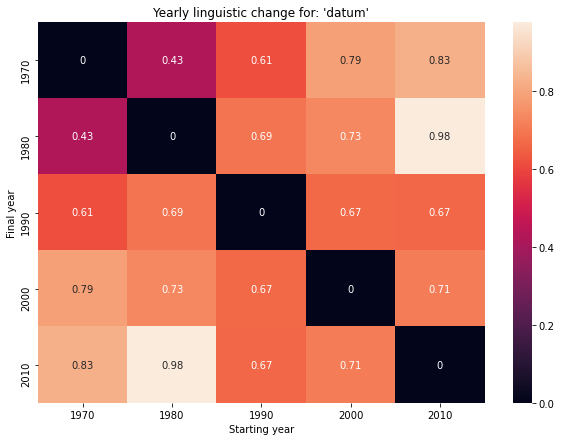

In [60]:
# The change of datum through different decade is large.
# This probably hints to the growing of data-driven papers, contrast to theory-driven economics.
targetWord = 'datum'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [61]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1170 words to compare


In [62]:
wordDivergences[:10]

[('state', 3.045879766345024),
 ('long', 2.9330556392669678),
 ('rate', 2.7101940512657166),
 ('exchange', 2.690748170018196),
 ('term', 2.6847845166921616),
 ('short', 2.680498704314232),
 ('labor', 2.660972148180008),
 ('datum', 2.65369713306427),
 ('unite', 2.6513387113809586),
 ('run', 2.632743462920189)]

state


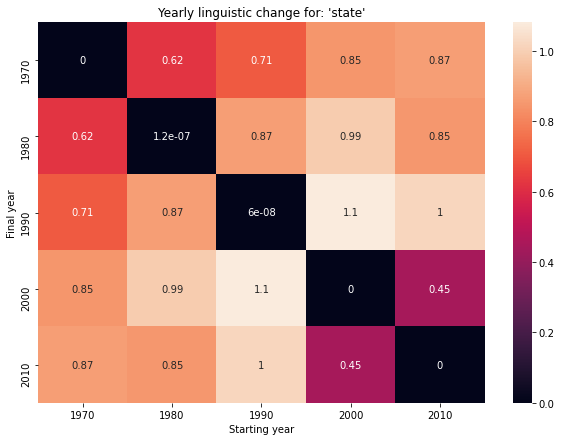

In [65]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()